In [1]:
from diffusion.utils import *
from collections import defaultdict
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

base_composuite_data_path = '/Users/shubhankar/Developer/compositional-rl-synth-data/data'
base_synthetic_data_path = '/Users/shubhankar/Developer/compositional-rl-synth-data/results'

def process_data(transitions_datasets):

    combined_dict = defaultdict(list)
    which_dataset = []

    for idx, data in enumerate(transitions_datasets):
        for key in data.keys():
            combined_dict[key].append(data[key])
        which_dataset.extend([idx] * len(data[key]))

    combined_transitions_datasets = {key: np.concatenate(values, axis=0) for key, values in combined_dict.items()}
    processed_data = make_inputs(combined_transitions_datasets)

    return processed_data, np.array(which_dataset)

In [2]:
dataset_type = 'expert-iiwa-offline-comp-data'

robots = ['IIWA']
objs = ['Box', 'Dumbbell', 'Hollowbox', 'Plate']
obsts = ['None']
tasks = ['Push']

In [3]:
composuite_datasets = load_multiple_composuite_datasets(base_path=base_composuite_data_path,
                                                        dataset_type=dataset_type,
                                                        robots=robots, objs=objs, 
                                                        obsts=obsts, tasks=tasks)

composuite_transitions_datasets = [transitions_dataset(dataset) for dataset in composuite_datasets]
flattened_composuite_data, composuite_data_ids = process_data(composuite_transitions_datasets)

Loading data: 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]


In [4]:
synthetic_datasets = load_multiple_synthetic_datasets(base_path=base_synthetic_data_path,
                                                      robots=robots, objs=objs, 
                                                      obsts=obsts, tasks=tasks)
flattened_synthetic_data, synthetic_data_ids = process_data(synthetic_datasets)

Loading data: 100%|██████████| 4/4 [00:00<00:00, 1112.62it/s]


In [5]:
print(flattened_composuite_data.shape, flattened_synthetic_data.shape)

(3999996, 196) (400000, 196)


In [6]:
random_indices = np.random.choice(flattened_composuite_data.shape[0], 10000, replace=False)
sampled_composuite_data = flattened_composuite_data[random_indices]
sample_composuite_data_ids = composuite_data_ids[random_indices]

random_indices = np.random.choice(flattened_synthetic_data.shape[0], 10000, replace=False)
sampled_synthetic_data = flattened_synthetic_data[random_indices]
sample_synthetic_data_ids = synthetic_data_ids[random_indices]

In [7]:
print(sampled_composuite_data.shape, sampled_synthetic_data.shape)

(10000, 196) (10000, 196)


In [8]:
combined_data = np.concatenate((sampled_composuite_data, sampled_synthetic_data), axis=0)
combined_data_ids = np.concatenate((sample_composuite_data_ids, sample_synthetic_data_ids), axis=0)


In [9]:
composuite_origin = np.zeros(sample_composuite_data_ids.shape[0], dtype=int)  # 0 for composuite
synthetic_origin = np.ones(sample_synthetic_data_ids.shape[0], dtype=int)   # 1 for synthetic

combined_data = np.concatenate((sampled_composuite_data, sampled_synthetic_data), axis=0)
combined_ids = np.concatenate((sample_composuite_data_ids, sample_synthetic_data_ids), axis=0)
combined_origins = np.concatenate((composuite_origin, synthetic_origin), axis=0)

In [10]:
normalized_data = StandardScaler().fit_transform(combined_data)
tsne = TSNE(n_components=2, random_state=42)
embeddings = tsne.fit_transform(normalized_data)

In [11]:
tuples = []
for robot in robots:
    for obj in objs:
        for obst in obsts:
            for task in tasks:
                tuples.append((robot + '_' + obj + '_' + obst + '_' + task))

id_to_name = {idx: t for idx, t in enumerate(tuples)}

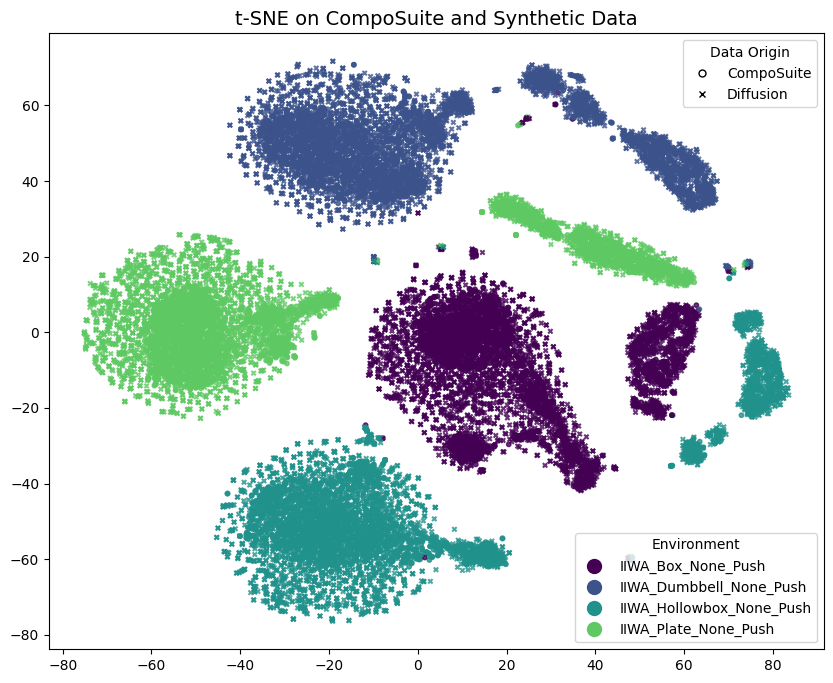

In [12]:
cmap = matplotlib.colormaps['viridis']
unique_ids = list(id_to_name.keys())
id_to_color = {id: cmap(i / len(unique_ids)) for i, id in enumerate(unique_ids)}

plt.figure(figsize=(10, 8))

scatter_composuite = plt.scatter(
    embeddings[combined_origins == 0, 0],
    embeddings[combined_origins == 0, 1],
    c=[id_to_color[id] for id in combined_ids[combined_origins == 0]],
    alpha=0.8,
    marker='o',
    s=10
)

scatter_synthetic = plt.scatter(
    embeddings[combined_origins == 1, 0],
    embeddings[combined_origins == 1, 1],
    c=[id_to_color[id] for id in combined_ids[combined_origins == 1]],
    alpha=0.8,
    marker='x',
    s=10
)

# Origin legend
origin_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markeredgecolor='black', markersize=5, label='CompoSuite'),
    Line2D([0], [0], marker='x', color='w', markeredgecolor='black', markersize=5, label='Diffusion')
]

ax = plt.gca()
origin_legend = ax.legend(
    handles=origin_legend_elements,
    loc='upper right',
    title='Data Origin',
    fontsize=10,
    title_fontsize=10
)

# Environment legend
environment_legend_elements = [
    Line2D([0], [0], marker='o', color=id_to_color[id], linestyle='None', markersize=10, label=f'{id_to_name[id]}')
    for id in unique_ids
]

ax.legend(
    handles=environment_legend_elements,
    loc='lower right',
    title='Environment',
    fontsize=10,
    title_fontsize=10,
    bbox_to_anchor=(1, 0)
)

ax.add_artist(origin_legend)

plt.title('t-SNE on CompoSuite and Synthetic Data', fontsize=14)
plt.show()